# Composing and fitting distributions with Carl

Gilles Louppe, January 2016.

This notebook introduces the `carl.distributions` module. It illustrates how distributions can be defined and composed, and how their parameters can be fit to data. 

*Disclaimer*: This module is meant to be a proof-of-concept that a full Python+Theano based RooFit equivalent could reallistically be achieved. At the moment, the module remains very experimental and should not be used in production.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Base API

All base distributions from `carl.distributions` implement the `DistributionMixin` interface, providing the following methods:

- `pdf(X)` for computing the probability density at `X`
- `nllf(X)` for computing `-log(pdf(X))`
- `rvs(n_samples)` for sampling data
- `cdf(X)` for computing the cumulative density at `X` (for 1D)
- `ppf(p)` for computing the `p`-th quantile (for 1D)

Parameters of a distribution (e.g., the location `mu` of a normal distribution) are specified at initialization.

In [2]:
from carl.distributions import Normal
p = Normal(mu=0.0, sigma=1.0)

In [3]:
reals = np.linspace(-5, 5, num=1000)
pdf = p.pdf(X=reals.reshape(-1, 1)) # X is a 2D array of shape n_samples x n_features
print(pdf[:10])

[  1.48671951e-06   1.56294518e-06   1.64291438e-06   1.72680223e-06
   1.81479157e-06   1.90707332e-06   2.00384677e-06   2.10531999e-06
   2.21171010e-06   2.32324372e-06]


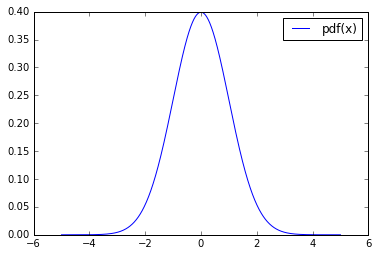

In [4]:
plt.plot(reals, pdf,label="pdf(x)")
plt.legend(loc="best")

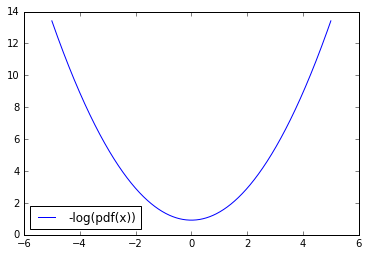

In [5]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.nll(reals.reshape(-1, 1)), label="-log(pdf(x))")
plt.legend(loc="best")

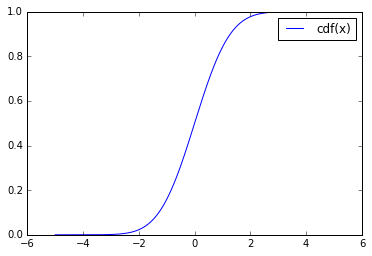

In [6]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.cdf(reals.reshape(-1, 1)), label="cdf(x)")
plt.legend(loc="best")

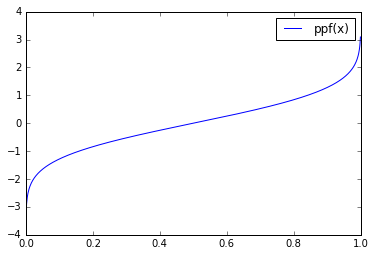

In [7]:
reals = np.linspace(0, 1, num=1000)
plt.plot(reals, p.ppf(reals.reshape(-1, 1)), label="ppf(x)")
plt.legend(loc="best")

In [8]:
p.rvs(n_samples=10000)

array([[ 0.63083619],
       [-0.46827968],
       [-1.0256046 ],
       ..., 
       [-0.17512356],
       [ 0.70047257],
       [-1.08143208]])

## Advanced API

As shown above for simple cases, parameters of a distribution can be specified as scalars. In more complex situations, arbitrary Theano symbolic expressions defined from shared variables or constants can also be used to specify parameters, as demonstrated below. 

In [9]:
a = theano.shared(1.0, name="a")
b = T.constant(0.5, name="b")
p = Normal(mu=a * b, sigma=2.0)

Note: Under the hood, if a parameter is specified as a scalar, then it is in fact automatically embedded into a Theano shared variable. 

In [10]:
# Parameters are Theano symbolic expressions
print(type(p.mu))
print(type(p.sigma))  # sigma=2.0 was embedded into a shared variable

<class 'theano.tensor.var.TensorVariable'>
<class 'theano.tensor.sharedvar.ScalarSharedVariable'>


By construction, `p.mu` is a Theano symbolic expression which depends on several inputs, in this case `a` and `b`. Accordingly, the actual variables (or hyper-parameters) that fully define `p` are the shared variables `a` (created explicitly) and `sigma` (created implicitly from the scalar `2.0`). In particular, `mu` is not an hyper-parameter of `p` since it is itself defined from the variable `a` and the constant `b`.

In terms of API, inputs of all expressions specified at initialization form together the hyper-parameters of the distribution, provided they are Theano shared variables. Hyper-parameters are stored in `p.parameters_`, while constants are stored in `p.constants_`.

In [11]:
p.parameters_  # all input parameters (note that mu is not part of those!)

{a, sigma}

In [12]:
p.constants_   # all input constants`

{TensorConstant{0.5}}

Additionally, parameter expressions can be defined in terms of free Theano variables that are not (yet) tied to any value. These auxiliary inputs will need to be passed at evaluation. All required extra inputs are stored in `p.observeds_`.

In [13]:
a = T.dmatrix(name="a")  # free input to be specified at evaluation
b = theano.shared(-1.0, name="b")
c = theano.shared(1.0, name="c")
p = Normal(mu=a*b + c)

In [14]:
p.parameters_

{b, sigma, c}

In [15]:
p.constants_

set()

In [16]:
p.observeds_

{a}

In [17]:
p.pdf(X=np.array([[0.0], [0.0]]),
      a=np.array([[1.0], [2.0]]))  # specify the auxiliary input `a` at evaluation

array([ 0.39894228,  0.24197072])

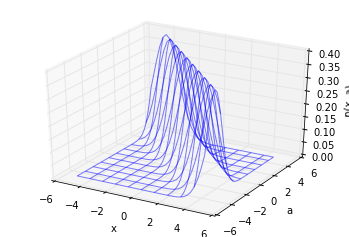

In [18]:
# Plot pdf(x, a)
import mpl_toolkits.mplot3d.axes3d as axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

Xs = np.arange(-5, 5, 0.25)
As = np.arange(-5, 5, 0.25)
Xs, As = np.meshgrid(Xs, As)

Ps = p.pdf(X=Xs.reshape(-1, 1), 
           a=As.reshape(-1, 1))
Ps = Ps.reshape(Xs.shape)

ax.plot_wireframe(Xs, As, Ps, rstride=4, cstride=4, alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("a")
ax.set_zlabel("p(x, a)")

plt.show()

## Composing mixtures

Mixtures distributions can be composed from a set of other distribution objects, as long as they implement the `DistributionMixin` API.

Weights assigned to components are themselves parameters, and can be provided either as a list of scalars or as a list of Theano expressions. 

In [19]:
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

g = theano.shared(0.05, name="g") 
p = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g])

In [20]:
p.parameters_  # union of all component parameters + g

{mu, g, mu, sigma, sigma, sigma, mu}

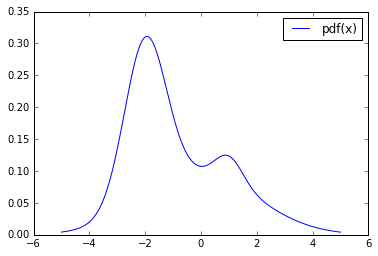

In [21]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.pdf(reals.reshape(-1, 1)), label="pdf(x)")
plt.legend()

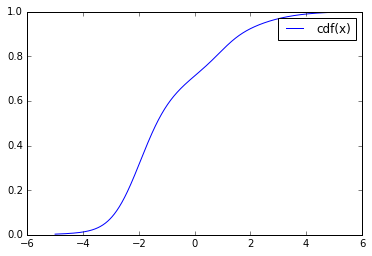

In [22]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.cdf(reals.reshape(-1, 1)), label="cdf(x)")
plt.legend()

In [23]:
p.weights

[Elemwise{sub,no_inplace}.0, Elemwise{sub,no_inplace}.0, g]

In [24]:
p.compute_weights()

array([ 0.475,  0.475,  0.05 ])

Note that weights are automatically normalized such that they sum to 1.

## Fitting parameters to data

Finally, distribution objects also implement a `fit` method for fitting through maximum likelihood all parameters from `p.parameters_` 

The Theano expression engine is used to symbolically derive the gradient of the objective function with respect to the parameters. This gradient function is then used to guide to underlying optimization algorithm. If needed, bounds and constraints can also be specified.

In [25]:
# Target distribution
p0 = Mixture(components=[Normal(mu=1.0, sigma=1.0), Normal(mu=4.0, sigma=1.0)],
             weights=[0.7, 0.3])

# Fit components[0].mu and mixture weights, freeze all others
w = theano.shared(0.5, name="w")
p1 = Mixture(components=[Normal(mu=0.0, sigma=T.constant(1.0)), 
                         Normal(mu=T.constant(4.0), sigma=T.constant(1.0))],
             weights=[w, 1.0 - w])
p1.parameters_

{mu, w}

In [26]:
X = p0.rvs(10000)
p1.fit(X, bounds=[{"param": w, "bounds": (0.5, 1.0)}], use_gradient=False)

Mixture(components=[Normal(mu=mu, sigma=TensorConstant{1.0}), Normal(mu=TensorConstant{4.0}, sigma=TensorConstant{1.0})],
    weights=[w, Elemwise{sub,no_inplace}.0])

In [27]:
p1.components[0].mu.eval()

array(0.9913026781609061)

In [28]:
p1.compute_weights()

array([ 0.70343782,  0.29656218])

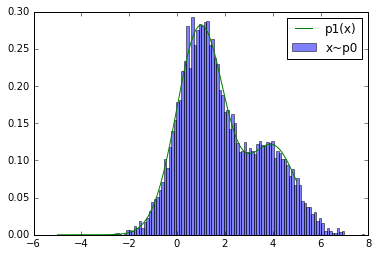

In [29]:
reals = np.linspace(-5, 5, num=1000)
plt.hist(X.ravel(), bins=100, normed=1, alpha=0.5, label="x~p0")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label="p1(x)")
plt.legend()